Install dependencies

In [1]:
!pip install safetensors torch --quiet

In [2]:
!pip install --upgrade torch --index-url https://download.pytorch.org/whl/nightly/cu124

Looking in indexes: https://download.pytorch.org/whl/nightly/cu124


Load your config.json

In [3]:
import json, types

CONFIG_PATH = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/config.json"   # <- change this
MODEL_DIR   = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"              # folder containing model.safetensors

with open(CONFIG_PATH, "r") as f:
    cfg_dict = json.load(f)

# turn into attribute-style object
config = types.SimpleNamespace(**cfg_dict)

config


namespace(architectures=['LlamaForCausalLM'],
          attention_bias=False,
          attention_dropout=0.0,
          bos_token_id=0,
          eos_token_id=0,
          hidden_act='silu',
          hidden_size=576,
          initializer_range=0.041666666666666664,
          intermediate_size=1536,
          is_llama_config=True,
          max_position_embeddings=8192,
          model_type='llama',
          num_attention_heads=9,
          num_hidden_layers=30,
          num_key_value_heads=3,
          pretraining_tp=1,
          rms_norm_eps=1e-05,
          rope_interleaved=False,
          rope_scaling=None,
          rope_theta=100000,
          tie_word_embeddings=True,
          torch_dtype='bfloat16',
          transformers_version='4.40.1',
          use_cache=True,
          vocab_size=49152)

Core building blocks (RMSNorm + RoPE)

In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        # x: (B,T,C)
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

In [4]:
class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin


Attention with GQA + causal mask

In [5]:
class LlamaAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.num_kv_heads = config.num_key_value_heads
        self.head_dim = self.hidden_size // self.num_heads
        assert self.head_dim * self.num_heads == self.hidden_size

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = config.attention_dropout

    def forward(self, x, attention_mask=None):
        """
        x: (B,T,C)
        attention_mask: optional (B,1,T,T) additive mask with -inf on blocked positions
        """
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)   # (B,h,T,d)
        k = self.k_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)
        v = self.v_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)

        # RoPE
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q, sin, cos)
        k = apply_rope(k, sin, cos)

        # GQA: repeat kv to match q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,h,T,d)
            v = v.repeat_interleave(repeat_factor, dim=1)

        # scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)  # (B,h,T,T)

        # causal mask
        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        # optional extra mask (padding, etc.)
        #if attention_mask is not None:
        #    attn_scores = attn_scores + attention_mask

        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = F.dropout(attn_probs, p=self.attn_dropout, training=self.training)

        out = torch.matmul(attn_probs, v)  # (B,h,T,d)
        out = out.transpose(1,2).contiguous().view(B, T, C)
        return self.o_proj(out)


MLP + Transformer block

In [6]:
class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))


In [7]:
class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out


Full LLaMA Causal LM

In [19]:
class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss



Build the model

In [21]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)


True
NVIDIA GB10
13.0


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bia

134.515008

In [23]:
import hashlib
import torch

def tensor_hash(t):
    # Convert BF16 -> FP32 because numpy doesn't support BF16
    arr = t.detach().cpu().to(torch.float32).numpy()
    return hashlib.md5(arr.tobytes()).hexdigest()

# Pick a specific layer
before_hash = tensor_hash(model.model.layers[0].self_attn.q_proj.weight)
print("Before:", before_hash)


Before: ef1ff450973e3e25306fd39150a5362c


Load weights from model.safetensors

In [24]:
from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

print("After:", layer.view(-1)[:5])

print("Missing keys:", len(missing))
print("Unexpected keys:", len(unexpected))

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

Before: tensor([-0.0152,  0.0018,  0.0300,  0.0149, -0.0356], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<SliceBackward0>)
After: tensor([-0.0894,  0.1367, -0.1045, -0.7188,  1.1797], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<SliceBackward0>)
Missing keys: 1
Unexpected keys: 0
Example missing: ['lm_head.weight']
Example unexpected: []


In [25]:
missing, unexpected = model.load_state_dict(state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")


Missing keys: ['lm_head.weight']
Unexpected keys: []
→ Tied lm_head.weight to embed_tokens.weight


Sanity test forward pass

In [26]:
from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)


In [27]:
with open("input.txt", "r") as f:
    text = f.read()

In [28]:

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

using device: cuda


In [29]:
import torch

SEQ_LEN = config.max_position_embeddings  # 8192

# 1. Tokenize
input_ids = tokenizer(text).input_ids
print("Total tokens:", len(input_ids))

# 2. Chunk
chunks = [input_ids[i:i+SEQ_LEN] for i in range(0, len(input_ids), SEQ_LEN)]
print("Chunks:", len(chunks))

# 3. Pad
def pad(x):
    return x + [tokenizer.pad_token_id or 0] * (SEQ_LEN - len(x))

padded_chunks = [torch.tensor(pad(c)).long() for c in chunks]

# 4. Batching
batch_size = 2
batches = [
    torch.stack(padded_chunks[i:i+batch_size])
    for i in range(0, len(padded_chunks), batch_size)
]

# 5. Forward pass
batch = batches[0].cuda()   # (2, 8192)
with torch.no_grad():
    out = model(batch)

print("Output shape:", out)  # (2, 8192, vocab)


Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Total tokens: 341094
Chunks: 42
Output shape: (tensor([[[ 17.3750,   3.5625,   3.6562,  ...,  11.9375,  13.6875,  13.7500],
         [ 10.5000,  -6.6562,  -6.5938,  ...,  -2.1719,   2.9531,   0.7617],
         [  4.5625, -12.8750, -12.8125,  ...,  -4.1250,   1.8594,  -3.4688],
         ...,
         [ 21.5000,   8.9375,   9.0625,  ...,  14.3125,  13.6250,  14.6875],
         [ 23.3750,   8.4375,   8.5000,  ...,  15.0000,  15.2500,  15.5000],
         [ 21.5000,   6.9062,   7.0000,  ...,  13.1875,  13.6250,  14.0000]],

        [[  9.4375,  -1.7422,  -1.6250,  ...,   7.4688,   8.3125,   4.5938],
         [  7.2500,  -3.7344,  -3.6406,  ...,   1.3281,   4.1250,   1.7969],
         [ 18.6250,   2.1094,   2.2500,  ...,  11.0000,  12.9375,  10.5000],
         ...,
         [ 21.7500,   6.7188,   6.7812,  ...,  13.1250,  14.3125,  12.4375],
         [ 20.6250,   3.8906,   3.9688,  ...,  11.1875,  12.0000,   9.6875],
         [ 15.8750,   1.1953,   1.2656,  ...,   9.1250,   9.9375,   7.0938]]

In [30]:
print(-torch.log(torch.tensor(1/50257)))

tensor(10.8249)


In [31]:
from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y


In [32]:
device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    logits, loss = model(x, y)   # now it works!
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")


Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 440.0421 | dt: 3281.37ms | tok/sec: 2496.52
step 1 | loss: 131.2214 | dt: 2571.89ms | tok/sec: 3185.21
step 2 | loss: 85.2180 | dt: 2567.72ms | tok/sec: 3190.38
step 3 | loss: 87.4907 | dt: 2572.76ms | tok/sec: 3184.12
step 4 | loss: 88.0964 | dt: 2574.11ms | tok/sec: 3182.45


In [34]:
# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        # x: (B,T,C)
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.num_kv_heads = config.num_key_value_heads
        self.head_dim = self.hidden_size // self.num_heads
        assert self.head_dim * self.num_heads == self.hidden_size

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = config.attention_dropout

    def forward(self, x, attention_mask=None):
        """
        x: (B,T,C)
        attention_mask: optional (B,1,T,T) additive mask with -inf on blocked positions
        """
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)   # (B,h,T,d)
        k = self.k_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)
        v = self.v_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)

        # RoPE
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q, sin, cos)
        k = apply_rope(k, sin, cos)

        # GQA: repeat kv to match q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,h,T,d)
            v = v.repeat_interleave(repeat_factor, dim=1)

        # scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)  # (B,h,T,T)

        # causal mask
        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        # optional extra mask (padding, etc.)
        #if attention_mask is not None:
        #    attn_scores = attn_scores + attention_mask

        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = F.dropout(attn_probs, p=self.attn_dropout, training=self.training)

        out = torch.matmul(attn_probs, v)  # (B,h,T,d)
        out = out.transpose(1,2).contiguous().view(B, T, C)
        return self.o_proj(out)

class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.fp32_precision = "tf32"
torch.backends.cudnn.fp32_precision = "tf32"


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    logits, loss = model(x, y)   # now it works!
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bia

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 424.2340 | dt: 2165.38ms | tok/sec: 3783.18
step 1 | loss: 121.4082 | dt: 2157.61ms | tok/sec: 3796.80
step 2 | loss: 83.0007 | dt: 2154.49ms | tok/sec: 3802.30
step 3 | loss: 81.3026 | dt: 2158.36ms | tok/sec: 3795.48
step 4 | loss: 79.0683 | dt: 2159.38ms | tok/sec: 3793.68


In [36]:
# added autocast

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        # x: (B,T,C)
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.num_kv_heads = config.num_key_value_heads
        self.head_dim = self.hidden_size // self.num_heads
        assert self.head_dim * self.num_heads == self.hidden_size

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = config.attention_dropout

    def forward(self, x, attention_mask=None):
        """
        x: (B,T,C)
        attention_mask: optional (B,1,T,T) additive mask with -inf on blocked positions
        """
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1,2)   # (B,h,T,d)
        k = self.k_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)
        v = self.v_proj(x).view(B, T, self.num_kv_heads, self.head_dim).transpose(1,2) # (B,kv,T,d)

        # RoPE
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q, sin, cos)
        k = apply_rope(k, sin, cos)

        # GQA: repeat kv to match q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,h,T,d)
            v = v.repeat_interleave(repeat_factor, dim=1)

        # scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)  # (B,h,T,T)

        # causal mask
        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        # optional extra mask (padding, etc.)
        #if attention_mask is not None:
        #    attn_scores = attn_scores + attention_mask

        causal = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal, float("-inf"))

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = F.dropout(attn_probs, p=self.attn_dropout, training=self.training)

        out = torch.matmul(attn_probs, v)  # (B,h,T,d)
        out = out.transpose(1,2).contiguous().view(B, T, C)
        return self.o_proj(out)

class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.fp32_precision = "tf32"
torch.backends.cudnn.fp32_precision = "tf32"


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)

    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bia

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 435.6360 | dt: 1701.36ms | tok/sec: 4814.96
step 1 | loss: 127.3702 | dt: 1692.46ms | tok/sec: 4840.30
step 2 | loss: 82.7005 | dt: 1697.36ms | tok/sec: 4826.32
step 3 | loss: 81.7776 | dt: 1693.87ms | tok/sec: 4836.27
step 4 | loss: 80.6131 | dt: 1697.14ms | tok/sec: 4826.94


In [44]:
# changed the Attention block with SDPA

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        # x: (B,T,C)
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttentionSDPA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads         # Hq
        self.num_kv_heads = config.num_key_value_heads      # Hkv
        self.head_dim = self.hidden_size // self.num_heads

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = float(getattr(config, "attention_dropout", 0.0))

    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        # Project to Q, K, V  -> (B,T,H,D)
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)
        v = self.v_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)

        # RoPE wants (B,H,T,D)
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q.transpose(1, 2), sin, cos)  # (B,Hq,T,D)
        k = apply_rope(k.transpose(1, 2), sin, cos)  # (B,Hkv,T,D)
        v = v.transpose(1, 2)                        # (B,Hkv,T,D)  ✅ IMPORTANT

        # GQA: expand K,V heads to match Q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)
            v = v.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)

        # SDPA fused causal attention
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout if self.training else 0.0,
            is_causal=True,
        )  # (B,Hq,T,D)

        out = out.transpose(1, 2).reshape(B, T, C)
        return self.o_proj(out)


class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttentionSDPA(config)
        #self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.fp32_precision = "tf32"
torch.backends.cudnn.fp32_precision = "tf32"


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)

    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionSDPA(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152,

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 437.2581 | dt: 650.46ms | tok/sec: 12594.08
step 1 | loss: 128.7806 | dt: 640.79ms | tok/sec: 12784.19
step 2 | loss: 89.0142 | dt: 643.58ms | tok/sec: 12728.78
step 3 | loss: 87.2735 | dt: 640.43ms | tok/sec: 12791.35
step 4 | loss: 86.6007 | dt: 640.86ms | tok/sec: 12782.75



InductorError: CalledProcessError: Command '['/usr/bin/gcc', '/tmp/tmp8ug7vhc2/cuda_utils.c', '-O3', '-shared', '-fPIC', '-Wno-psabi', '-o', '/tmp/tmp8ug7vhc2/cuda_utils.cpython-312-aarch64-linux-gnu.so', '-lcuda', '-L/home/shankar7ganesh/TSAI_ERA_v4_SmolLM_135M_S13/.venv/lib/python3.12/site-packages/triton/backends/nvidia/lib', '-L/lib/aarch64-linux-gnu', '-I/home/shankar7ganesh/TSAI_ERA_v4_SmolLM_135M_S13/.venv/lib/python3.12/site-packages/triton/backends/nvidia/include', '-I/tmp/tmp8ug7vhc2', '-I/usr/include/python3.12']' returned non-zero exit status 1.

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"

🧨 Why torch.compile() fails on your DGX Spark?
NVIDIA DGX Spark uses:

✔ ARM CPU (AArch64)
✔ Blackwell GPU
❌ Triton compiler is x86_64 only
❌ PyTorch Inductor requires Triton
❌ Triton CUDA backend cannot compile kernel modules on ARM

So torch.compile() cannot generate fused kernels.

In [52]:
import torch.nn.functional as F
print(hasattr(F, "rms_norm"))


True


In [53]:
# replaced RMSNorms code

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return torch.nn.functional.rms_norm(
            x, 
            normalized_shape=(x.size(-1),),
            weight=self.weight,
            eps=self.eps,
        )

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttentionSDPA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads         # Hq
        self.num_kv_heads = config.num_key_value_heads      # Hkv
        self.head_dim = self.hidden_size // self.num_heads

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = float(getattr(config, "attention_dropout", 0.0))

    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        # Project to Q, K, V  -> (B,T,H,D)
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)
        v = self.v_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)

        # RoPE wants (B,H,T,D)
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q.transpose(1, 2), sin, cos)  # (B,Hq,T,D)
        k = apply_rope(k.transpose(1, 2), sin, cos)  # (B,Hkv,T,D)
        v = v.transpose(1, 2)                        # (B,Hkv,T,D)  ✅ IMPORTANT

        # GQA: expand K,V heads to match Q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)
            v = v.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)

        # SDPA fused causal attention
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout if self.training else 0.0,
            is_causal=True,
        )  # (B,Hq,T,D)

        out = out.transpose(1, 2).reshape(B, T, C)
        return self.o_proj(out)


class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttentionSDPA(config)
        #self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.fp32_precision = "tf32"
torch.backends.cudnn.fp32_precision = "tf32"


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)

    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionSDPA(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152,

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 434.6060 | dt: 566.15ms | tok/sec: 14469.57
step 1 | loss: 127.9871 | dt: 536.08ms | tok/sec: 15281.41
step 2 | loss: 87.6432 | dt: 535.95ms | tok/sec: 15284.89
step 3 | loss: 83.6997 | dt: 537.94ms | tok/sec: 15228.52
step 4 | loss: 82.9705 | dt: 535.74ms | tok/sec: 15291.08


In [54]:
# changing 
'''
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
'''

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return torch.nn.functional.rms_norm(
            x, 
            normalized_shape=(x.size(-1),),
            weight=self.weight,
            eps=self.eps,
        )

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttentionSDPA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads         # Hq
        self.num_kv_heads = config.num_key_value_heads      # Hkv
        self.head_dim = self.hidden_size // self.num_heads

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = float(getattr(config, "attention_dropout", 0.0))

    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        # Project to Q, K, V  -> (B,T,H,D)
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)
        v = self.v_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)

        # RoPE wants (B,H,T,D)
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q.transpose(1, 2), sin, cos)  # (B,Hq,T,D)
        k = apply_rope(k.transpose(1, 2), sin, cos)  # (B,Hkv,T,D)
        v = v.transpose(1, 2)                        # (B,Hkv,T,D)  ✅ IMPORTANT

        # GQA: expand K,V heads to match Q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)
            v = v.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)

        # SDPA fused causal attention
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout if self.training else 0.0,
            is_causal=True,
        )  # (B,Hq,T,D)

        out = out.transpose(1, 2).reshape(B, T, C)
        return self.o_proj(out)


class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttentionSDPA(config)
        #self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)

train_loader = DataLoaderLite(B=8, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)

    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionSDPA(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152,

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 41 batches
step 0 | loss: 432.9732 | dt: 544.42ms | tok/sec: 15047.07
step 1 | loss: 125.1638 | dt: 528.67ms | tok/sec: 15495.37
step 2 | loss: 89.2411 | dt: 532.10ms | tok/sec: 15395.54
step 3 | loss: 89.6816 | dt: 535.72ms | tok/sec: 15291.51
step 4 | loss: 86.6060 | dt: 529.72ms | tok/sec: 15464.65


In [4]:
# increasing the batch size x2

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return torch.nn.functional.rms_norm(
            x, 
            normalized_shape=(x.size(-1),),
            weight=self.weight,
            eps=self.eps,
        )

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttentionSDPA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads         # Hq
        self.num_kv_heads = config.num_key_value_heads      # Hkv
        self.head_dim = self.hidden_size // self.num_heads

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = float(getattr(config, "attention_dropout", 0.0))

    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        # Project to Q, K, V  -> (B,T,H,D)
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)
        v = self.v_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)

        # RoPE wants (B,H,T,D)
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q.transpose(1, 2), sin, cos)  # (B,Hq,T,D)
        k = apply_rope(k.transpose(1, 2), sin, cos)  # (B,Hkv,T,D)
        v = v.transpose(1, 2)                        # (B,Hkv,T,D)  ✅ IMPORTANT

        # GQA: expand K,V heads to match Q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)
            v = v.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)

        # SDPA fused causal attention
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout if self.training else 0.0,
            is_causal=True,
        )  # (B,Hq,T,D)

        out = out.transpose(1, 2).reshape(B, T, C)
        return self.o_proj(out)


class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttentionSDPA(config)
        #self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)
# trial batch size 16 - same speed like before awesome
# trial batch size 32 - same speed like before awesome
# trial batch size 64 - hanging after 1st iteration.

train_loader = DataLoaderLite(B=32, T=1024, tokenizer_path=TOKENIZER_DIR)

import time

for i in range(5):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)

    loss.backward()
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

/home/shankar7ganesh/TSAI_ERA_v4_SmolLM_135M_S13/.venv/lib/python3.12/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
/home/shankar7ganesh/TSAI_ERA_v4_SmolLM_135M_S13/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionSDPA(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152,

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 10 batches
step 0 | loss: 433.2917 | dt: 3884.80ms | tok/sec: 8434.92
step 1 | loss: 124.0382 | dt: 2216.75ms | tok/sec: 14781.97
step 2 | loss: 89.7909 | dt: 2138.37ms | tok/sec: 15323.81
step 3 | loss: 86.3727 | dt: 2136.66ms | tok/sec: 15336.08
step 4 | loss: 85.2940 | dt: 2126.21ms | tok/sec: 15411.43


In [22]:
# increasing the batch size x2 + grad_accum = 4 
''' NOT MUCH difference'''

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return torch.nn.functional.rms_norm(
            x, 
            normalized_shape=(x.size(-1),),
            weight=self.weight,
            eps=self.eps,
        )

class RotaryEmbedding(nn.Module):
    """
    HF-style RoPE, theta = rope_theta.
    Applies RoPE to first head_dim dims (which is full head_dim in LLaMA).
    """
    def __init__(self, head_dim, base=10000):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device, dtype):
        # positions: (seq_len,)
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)  # (T, head_dim/2)
        emb = torch.cat([freqs, freqs], dim=-1)            # (T, head_dim)
        sin = emb.sin()[None, None, :, :]                 # (1,1,T,head_dim)
        cos = emb.cos()[None, None, :, :]                 # (1,1,T,head_dim)
        return sin.to(dtype), cos.to(dtype)


def apply_rope(x, sin, cos):
    """
    x: (B, n_heads, T, head_dim)
    sin/cos: (1,1,T,head_dim)
    """
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    # rotate pairs
    x_rot = torch.stack((-x2, x1), dim=-1).reshape_as(x)
    return x * cos + x_rot * sin

class LlamaAttentionSDPA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads         # Hq
        self.num_kv_heads = config.num_key_value_heads      # Hkv
        self.head_dim = self.hidden_size // self.num_heads

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

        self.rope = RotaryEmbedding(self.head_dim, base=config.rope_theta)
        self.attn_dropout = float(getattr(config, "attention_dropout", 0.0))

    def forward(self, x, attention_mask=None):
        B, T, C = x.shape
        device, dtype = x.device, x.dtype

        # Project to Q, K, V  -> (B,T,H,D)
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim)
        k = self.k_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)
        v = self.v_proj(x).reshape(B, T, self.num_kv_heads, self.head_dim)

        # RoPE wants (B,H,T,D)
        sin, cos = self.rope(T, device=device, dtype=dtype)
        q = apply_rope(q.transpose(1, 2), sin, cos)  # (B,Hq,T,D)
        k = apply_rope(k.transpose(1, 2), sin, cos)  # (B,Hkv,T,D)
        v = v.transpose(1, 2)                        # (B,Hkv,T,D)  ✅ IMPORTANT

        # GQA: expand K,V heads to match Q heads
        if self.num_kv_heads != self.num_heads:
            repeat_factor = self.num_heads // self.num_kv_heads
            k = k.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)
            v = v.repeat_interleave(repeat_factor, dim=1)  # (B,Hq,T,D)

        # SDPA fused causal attention
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout if self.training else 0.0,
            is_causal=True,
        )  # (B,Hq,T,D)

        out = out.transpose(1, 2).reshape(B, T, C)
        return self.o_proj(out)


class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj   = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.act = nn.SiLU()

    def forward(self, x):
        # LLaMA MLP = SiLU(gate_proj(x)) * up_proj(x) then down_proj
        return self.down_proj(self.act(self.gate_proj(x)) * self.up_proj(x))

class LlamaDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = LlamaAttentionSDPA(config)
        #self.self_attn = LlamaAttention(config)
        self.mlp = LlamaMLP(config)

        self.input_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, x, attention_mask=None):
        # attention
        h = x + self.self_attn(self.input_layernorm(x), attention_mask=attention_mask)
        # mlp
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

class LlamaModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, config.rms_norm_eps)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed_tokens(input_ids)
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        return self.norm(x)

class LlamaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # tie embeddings if needed
        if getattr(config, "tie_word_embeddings", False):
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, labels=None, attention_mask=None):
        # transformer hidden states
        h = self.model(input_ids, attention_mask=attention_mask)
        logits = self.lm_head(h)

        # INFERENCE PATH
        if labels is None:
            return logits, None

        # TRAINING PATH
        # shift for autoregressive loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        return logits, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if config.torch_dtype == "bfloat16" else torch.float16

# CHANGES IN CURRENT CODE
#torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


model = LlamaForCausalLM(config).to(device=device, dtype=dtype)
print (model.eval())

sum(p.numel() for p in model.parameters()) / 1e6

from safetensors.torch import load_file
import os

weights_path = os.path.join(MODEL_DIR, "model.safetensors")
state = load_file(weights_path)

layer = model.model.layers[0].self_attn.q_proj.weight

print("Before:", layer.view(-1)[:5])

# load into our model
missing, unexpected = model.load_state_dict(state, strict=False)

layer = model.model.layers[0].self_attn.q_proj.weight

print("After:", layer.view(-1)[:5])

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Fix for tied embeddings
if "lm_head.weight" in missing:
    model.lm_head.weight = model.model.embed_tokens.weight
    print("→ Tied lm_head.weight to embed_tokens.weight")

# print a few to debug if any mismatch
print("Example missing:", missing[:10])
print("Example unexpected:", unexpected[:10])

from transformers import AutoTokenizer

TOKENIZER_DIR = "models--HuggingFaceTB--SmolLM2-135M/snapshots/93efa2f097d58c2a74874c7e644dbc9b0cee75a2/"  # where tokenizer.json is
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

with open("input.txt", "r") as f:
    text = f.read()

from transformers import AutoTokenizer
import torch

class DataLoaderLite:
    def __init__(self, B, T, tokenizer_path=TOKENIZER_DIR):
        self.B = B
        self.T = T

        # load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # load raw text
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

        # tokenize entire dataset at once
        tokens = self.tokenizer(text).input_ids
        self.tokens = torch.tensor(tokens, dtype=torch.long)
        
        print(f"Loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # pointer
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T

        # get (B*T) + 1 tokens for labels
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]

        # reset if we hit the end
        if len(buf) < B*T + 1:
            self.current_position = 0
            buf = self.tokens[: B*T + 1]

        x = buf[:-1].view(B, T)  # (B, T)
        y = buf[1:].view(B, T)   # (B, T)

        self.current_position += B*T
        return x, y

device = "cuda"

model = LlamaForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# load weights if needed
# missing, unexpected = model.load_state_dict(state, strict=False)
# trial batch size 16 - same speed like before awesome
# trial batch size 32 - same speed like before awesome
# trial batch size 64 - hanging after 1st iteration.

train_loader = DataLoaderLite(B=16, T=1024, tokenizer_path=TOKENIZER_DIR)

grad_accum = 4
optimizer.zero_grad()

import time

for i in range(10):
    t0 = time.time()

    x, y = train_loader.next_batch()
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
        loss = loss/grad_accum
    
    loss.backward()

    #optimizer.step()

    if ((i+1) % grad_accum) == 0:
        optimizer.step()
        optimizer.zero_grad()

    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)

    print(f"step {i} | loss: {loss.item():.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionSDPA(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rope): RotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152,

Token indices sequence length is longer than the specified maximum sequence length for this model (341094 > 8192). Running this sequence through the model will result in indexing errors


Loaded 341094 tokens
1 epoch = 20 batches
step 0 | loss: 109.6663 | dt: 1022.70ms | tok/sec: 16020.29
step 1 | loss: 108.7750 | dt: 1019.81ms | tok/sec: 16065.69
step 2 | loss: 108.2115 | dt: 1022.03ms | tok/sec: 16030.81
step 3 | loss: 109.1347 | dt: 1070.70ms | tok/sec: 15302.21
step 4 | loss: 31.8584 | dt: 1020.77ms | tok/sec: 16050.56
step 5 | loss: 32.9130 | dt: 1028.16ms | tok/sec: 15935.28
step 6 | loss: 34.3935 | dt: 1026.78ms | tok/sec: 15956.70
step 7 | loss: 33.2719 | dt: 1069.57ms | tok/sec: 15318.26
step 8 | loss: 21.2987 | dt: 1031.79ms | tok/sec: 15879.20
step 9 | loss: 21.3444 | dt: 1013.05ms | tok/sec: 16172.91


In [45]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [46]:
model = model
inputs = x

with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::empty         1.97%       1.424ms         1.97%       1.424ms       6.748us         480 B         480 B           211  
                                  aten::embedding         0.06%      43.329us         0.44%     317.185us     317.185us           0 B           0 B             1  
                                    aten::reshape         1.65%       1.191ms         4.61%       3.335ms       8.509us           0 B           0 B           392  
                

In [47]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    with_flops=True
) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="flops", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               aten::mm         1.10%       2.481ms         3.05%       6.882ms      32.616us      90.088ms        38.83%     109.423ms     518.594us           211   2203318.223  
                                              aten::mul         0.95%       2.140ms         2.86%       6.450ms      21.357us      50.611ms        21.8

The Memory and Compute Requirement notebook¶
This notebook is a simple tool to estimate the memory and compute requirements for the solution of the problem. The notebook is divided into two sections: the first one is dedicated to the memory requirements, while the second one is dedicated to the compute requirements.

In [ ]:
# Some working statistics

# Model
vocabulary_size = 50257
embedding_dimensions = 768
num_attention_heads = 12
num_hidden_layers = 12
feed_forward_ratio = 4

import matplotlib.pyplot as plt

parameter_counts = {
    "Token Embeddings": vocabulary_size * embedding_dimensions,
    "Attention": (
        embedding_dimensions * 3 * embedding_dimensions + embedding_dimensions**2
    ) * num_hidden_layers,
    "MLP": (
        embedding_dimensions * feed_forward_ratio * embedding_dimensions * 2
    ) * num_hidden_layers,
    "Norm": embedding_dimensions * 2 * num_hidden_layers + embedding_dimensions,
    "Output": 0, # We share the embedding weights
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")


print(f"Total parameters: {total_parameter_count:,}")

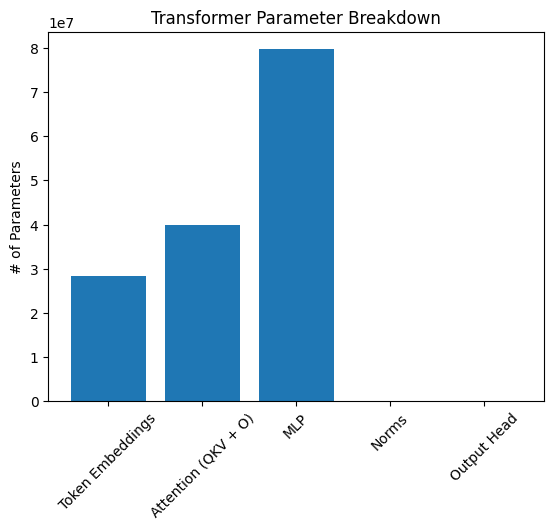

Token Embeddings               28,311,552      19.16%
Attention (QKV + O)            39,813,120      26.94%
MLP                            79,626,240      53.88%
Norms                              35,136       0.02%
Output Head                             0       0.00%

Total parameters: 147,786,048


In [6]:
import matplotlib.pyplot as plt

hidden = config.hidden_size
heads = config.num_attention_heads
layers = config.num_hidden_layers
ffn = config.intermediate_size
vocab = config.vocab_size
tie = getattr(config, "tie_word_embeddings", False)

parameter_counts = {
    "Token Embeddings": vocab * hidden,
    
    # Q, K, V projections: hidden → (3 * hidden)
    # Output projection: hidden → hidden
    "Attention (QKV + O)": (hidden * hidden * 4) * layers,

    # FFN (Gate + Up) + Down
    "MLP": (hidden * ffn * 2 + ffn * hidden) * layers,

    # RMSNorm layers
    "Norms": (hidden * 2 * layers + hidden),

    # LM head (if NOT tied)
    "Output Head": 0 if tie else hidden * vocab,
}

# Plot
plt.bar(parameter_counts.keys(), parameter_counts.values())
plt.title("Transformer Parameter Breakdown")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)
plt.show()

# Print table
total_parameter_count = sum(parameter_counts.values())
for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")

print(f"\nTotal parameters: {total_parameter_count:,}")
